In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import interpolate
import time
import torch
import torch.nn.functional as F
from torch.optim import LBFGS

interp_mode = "bilinear"
align_corners = True


#n_grids = [12,16,20,24,28,32,36,40]
#n_grids = [12,16]
#n_grids = [6,10,14,20,30,40,50]
#n_grids = [6,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,600,700,800,900,1000]
#n_grids = [10,20,30,40,50,60,70,80,90,100]
n_grids = [6,8,12,16,20,24,28,32,36,40,44,48]
#n_grids = [20]
#n_grids = [200]
theta_start = 0
theta_end = np.pi/2
r_start = 3
r_end = 4

a = 0.0
M = 1

errors = []
times = []
ii = 0


for n_grid in n_grids:
    print(n_grid)

    thetas = torch.linspace(theta_start,theta_end,steps=n_grid, dtype=torch.double)
    rs = torch.linspace(r_start,r_end,steps=n_grid, dtype=torch.double)
    theta_h = (theta_end - theta_start)/(n_grid-1)
    r_h  = (r_end - r_start)/(n_grid-1)

    RS, THETAS = torch.meshgrid(rs, thetas)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS = torch.transpose(RS,0,1)
    #THETAS = torch.transpose(THETAS,0,1)
    z = torch.transpose(torch.stack([RS.reshape(-1,), THETAS.reshape(-1,)]),0,1)
    
    #print(z)

    # t' = t + f1(r,theta)
    def f1(f1_free, n_grid):
        # f1_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f1_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f1_[:,:-1] = f1_free
        f1_[:,-1] = f1_free[:,-1]
        return f1_

    # r' = r + f2(r,theta)
    def f2(f2_free, n_grid):
        # f2_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f2_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f2_[:,:-1] = f2_free
        f2_[:,-1] = f2_free[:,-1]
        return f2_

    # theta' = theta + f3(r,theta)
    def f3(f3_free, n_grid):
        # f3_free has shape (n_grid, n_grid-2)
        # Along theta, zero at theta=0 and theta=pi/2
        f3_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f3_[:,1:-1] = f3_free
        return f3_

    # phi' = phi + f4(r,theta)
    def f4(f4_free, n_grid):
        # f4_free has shape (n_grid, n_grid-1).
        # Along theta, zero derivative at theta=pi/2
        f4_ = torch.zeros(n_grid,n_grid, dtype=torch.double)
        f4_[:,:-1] = f4_free
        f4_[:,-1] = f4_free[:,-1]
        return f4_
    
    
    def interp_free(f_free, n_grid, mode="0"):
        n_grid_old = f_free.shape[0]
        if mode == "0":
            f_ = f1(f_free, n_grid_old)
        else:
            f_ = f3(f_free, n_grid_old)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,:-1]
        else:
            f_free_new = F.interpolate(f_free_std, size=(n_grid,n_grid), mode=interp_mode, align_corners=align_corners)[0,0,:,1:-1]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def interp_free_test(f_free, n_grid, mode="0"):
        if mode == "0":
            f_ = f1(f_free, n_grid)
        else:
            f_ = f3(f_free, n_grid)
        f_free_std = f_.unsqueeze(dim=0).unsqueeze(dim=0)
        if mode == "0":
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,1:-3:2]
        else:
            f_free_new = F.interpolate(f_free_std, size=(2*n_grid-1,2*n_grid-1), mode=interp_mode, align_corners=align_corners)[0,0,1:-1:2,3:-3:2]
        return f_free_new#torch.transpose(f_free_new,0,1)#

    def decompose_free(f_free, n_grid):
        f1_free = f_free[:,:n_grid-1]
        f2_free = f_free[:,n_grid-1:2*n_grid-2]
        f3_free = f_free[:,2*n_grid-2:3*n_grid-4]
        f4_free = f_free[:,3*n_grid-4:4*n_grid-5]
        return (f1_free,f2_free,f3_free,f4_free)

    def compose_free(f1_free,f2_free,f3_free,f4_free):
        return torch.cat([f1_free, f2_free, f3_free, f4_free], dim=1)

    def interp_f_free(f_free, n_grid, n_grid_old):
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid_old)
        f1_free_new = interp_free(f1_free, n_grid, mode="0")
        f2_free_new = interp_free(f2_free, n_grid, mode="0")
        f3_free_new = interp_free(f3_free, n_grid, mode="1")
        f4_free_new = interp_free(f4_free, n_grid, mode="0")
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def interp_f_free_test(f_free, n_grid):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_free_new = interp_free_test(f1_free, n_grid, mode="0")
        f2_free_new = interp_free_test(f2_free, n_grid, mode="0")
        f3_free_new = interp_free_test(f3_free, n_grid, mode="1")
        f4_free_new = interp_free_test(f4_free, n_grid, mode="0")
        #print(f1_free_new.shape, f2_free_new.shape, f3_free_new.shape, f4_free_new.shape)
        f_free_new = compose_free(f1_free_new, f2_free_new, f3_free_new, f4_free_new)
        return f_free_new


    def r_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid+2,n_grid,dtype=torch.double)
        f_aug[1:-1] = f
        f_aug[0] = 2*f[0] - f[1]
        f_aug[-1] = 2*f[-1] - f[-2]
        f_r = (f_aug[2:] - f_aug[:-2])/(2*r_h)
        return f_r

    def theta_derivative(f, n_grid):
        f_aug = torch.zeros(n_grid,n_grid+2,dtype=torch.double)
        f_aug[:,1:-1] = f
        f_aug[:,0] = 2*f[:,0] - f[:,1]
        f_aug[:,-1] = 2*f[:,-1] - f[:,-2]
        f_theta = (f_aug[:,2:] - f_aug[:,:-2])/(2*theta_h)
        return f_theta

    def w(f1,f2,f3,f4, n_grid):
        f1_r = r_derivative(f1, n_grid).reshape(-1,)
        f2_r = r_derivative(f2, n_grid).reshape(-1,)
        f3_r = r_derivative(f3, n_grid).reshape(-1,)
        f4_r = r_derivative(f4, n_grid).reshape(-1,)
        f1_theta = theta_derivative(f1, n_grid).reshape(-1,)
        f2_theta = theta_derivative(f2, n_grid).reshape(-1,)
        f3_theta = theta_derivative(f3, n_grid).reshape(-1,)
        f4_theta = theta_derivative(f4, n_grid).reshape(-1,)
        ones = torch.ones(f1_r.shape[0], dtype=torch.double)

        stack1 = torch.stack([ones, f1_r, f1_theta, 0*ones])
        stack2 = torch.stack([0*ones, 1+f2_r, f2_theta, 0*ones])
        stack3 = torch.stack([0*ones, f3_r, 1+f3_theta, 0*ones])
        stack4 = torch.stack([0*ones, f4_r, f4_theta, ones])
        w_ = torch.stack([stack1, stack2, stack3, stack4])
        w_ = w_.permute(2,0,1)
        return w_

    def w_inv_invt(w):
        w_inv = torch.linalg.inv(w)
        w_invt = w_inv.permute(0,2,1)
        return w_inv, w_invt

    def gp(g, w):
        w_inv, w_invt = w_inv_invt(w)
        gp_ = torch.matmul(torch.matmul(w_invt, g), w_inv)
        return gp_

    def zp(z, f2, f3):
        f2 = f2.reshape(-1,)
        f3 = f3.reshape(-1,)
        rp = z[:,0] + f2
        thetap = z[:,1] + f3
        zp_ = torch.transpose(torch.stack([rp, thetap]),0,1)
        return zp_

    def g(x_, a=0.0):
        r = x_[:,0]
        theta = x_[:,1]
        bs = x_.shape[0]
        Sigma = r**2 + a**2*np.cos(theta)**2
        Delta = r**2 - 2*M*r + a**2
        one = torch.ones(bs, dtype=torch.double)
        g01 = g02 = g10 = g12 = g13 = g20 = g21 = g23 = g31 = g32 = 0*one
        g00 = -(1-2*M*r/Sigma)
        g03 = g30 = -2*M*a*r*torch.sin(theta)**2/Sigma
        g11 = Sigma/Delta
        g22 = Sigma
        g33 = (r**2+a**2+2*M*a**2*r*torch.sin(theta)**2/Sigma)*torch.sin(theta)**2
        #print(g00.shape, g01.shape, g02.shape, g03.shape)
        stack1 = torch.stack([g00, g01, g02, g03])
        stack2 = torch.stack([g10, g11, g12, g13])
        stack3 = torch.stack([g20, g21, g22, g23])
        stack4 = torch.stack([g30, g31, g32, g33])
        gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
        return gs

    def gp_space_target(zp):
        bs = zp.shape[0]
        one = torch.ones(bs, dtype=torch.double)
        g11 = one
        g12 = g13 = g21 = g23 = g31 = g32 = 0*one
        g22 = zp[:,0]**2
        g33 = zp[:,0]**2*torch.sin(zp[:,1])**2
        stack1 = torch.stack([g11,g12,g13])
        stack2 = torch.stack([g21,g22,g23])
        stack3 = torch.stack([g31,g32,g33])
        gs = torch.stack([stack1, stack2, stack3]).permute(2,0,1)
        return gs

    def error(f_free, mode="train"):
        f_free = f_free.reshape(n_grid, 4*n_grid-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid)
        f1_ = f1(f1_free, n_grid)
        f2_ = f2(f2_free, n_grid)
        f3_ = f3(f3_free, n_grid)
        f4_ = f4(f4_free, n_grid)
        g_ = g(z, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid)
        zp_ = zp(z,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid,n_grid,3,3)
        #print(gp_space): inconsistent here
        
        gp_space_target_ = gp_space_target(zp_).reshape(n_grid,n_grid,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    # Initialize next grid with the former solution
    if ii == 0:
    #if True:
        f_free = torch.zeros((n_grid,4*n_grid-5), dtype=torch.double)
        #f_free[:,:n_grid-1] = 1*M*(2*np.sqrt(rs/(2*M)) + 0.5*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = 2*M*(2*np.sqrt(rs/(2*M)) + 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        #f_free[:,:n_grid-1] = - 2*M*(2*np.sqrt(rs/(2*M)) - 1*np.log((np.sqrt(rs/(2*M))-1)/(np.sqrt(rs/(2*M))+1)))[:,np.newaxis]
        f_free[:,:n_grid-1] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,n_grid-1:2*(n_grid-1)] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free[:,2*(n_grid-1):3*n_grid-4] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,1:-1])
        f_free[:,3*n_grid-4:4*n_grid-5] = 0.001*(rs[:,np.newaxis] + thetas[np.newaxis,:-1])
        f_free = f_free.reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(f_free.shape)
    else:
        #best_free = torch.load('./results_grid/a_%.3f_grid_%d'%(1.0,50))
        #f_free_old = best_free.reshape(50, 4*50-5)
        #f_free = interp_f_free(f_free_old, n_grid, 50).reshape(-1,)
        f_free_old = best_free.reshape(n_grid_old, 4*n_grid_old-5)
        #print(f_free_old.shape)
        #print(n_grid, n_grid_old)
        f_free = interp_f_free(f_free_old, n_grid, n_grid_old).reshape(-1,)
        f_free = torch.nn.Parameter(f_free, requires_grad=True)
        #print(interp_f_free(f_free_old, n_grid, n_grid_old).shape)
    
    # "Testing"
    #rs_test, thetas_test = grid(n_grid)
    rs_test = (rs[1:] + rs[:-1])/2
    thetas_test = (thetas[1:] + thetas[:-1])/2
    f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
    #plt.matshow(f_free_test.reshape(n_grid-1,4*(n_grid-1)-5))
    RS_test, THETAS_test = torch.meshgrid(rs_test, thetas_test)
    # Transpose here is very important! Becareful of meshgrid and reshape stuff!
    #RS_test = torch.transpose(RS_test,0,1)
    #THETAS_test = torch.transpose(THETAS_test,0,1)
    z_test = torch.transpose(torch.stack([RS_test.reshape(-1,), THETAS_test.reshape(-1,)]),0,1)

    
    def error_test(f_free, mode="train"):
        #print(f_free.shape)
        f_free = f_free.reshape(n_grid-1, 4*(n_grid-1)-5)
        f1_free, f2_free, f3_free, f4_free = decompose_free(f_free, n_grid-1)
        f1_ = f1(f1_free, n_grid-1)
        f2_ = f2(f2_free, n_grid-1)
        f3_ = f3(f3_free, n_grid-1)
        f4_ = f4(f4_free, n_grid-1)
        g_ = g(z_test, a=a)
        w_ = w(f1_,f2_,f3_,f4_, n_grid-1)
        zp_test = zp(z_test,f2_,f3_)
        gp_space = gp(g_, w_)[:,1:,1:].reshape(n_grid-1,n_grid-1,3,3)
        
        gp_space_target_ = gp_space_target(zp_test).reshape(n_grid-1,n_grid-1,3,3)
        if mode == "train":
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,:]**2)
        else:
            error_ = torch.mean((gp_space-gp_space_target_)[1:-1,1:-1]**2)
        return error_
    
    def error_all(f_free, mode="train"):
        f_free_test = interp_f_free_test(f_free, n_grid).reshape(-1,)
        #print(interp_f_free_test(f_free, n_grid).shape)
        return error(f_free, mode=mode) + error_test(f_free_test, mode=mode)
    
    
    # Test and Train at the same time
    start = time.time()
    lr = 36/n_grid**2
    opt = LBFGS({f_free}, lr=lr, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000, line_search_fn='strong_wolfe')
    #opt = LBFGS({f_free}, lr=lr, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=1000)
    lr = 1e-2*(6/n_grid)**2
    #opt = torch.optim.Adam({f_free}, lr=lr, eps=1e-8)
    
    epochs = 300
    switch_epoch = 100
    log = 5
    best_loss = 1e20
    losses = []
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            loss = error_all(f_free, mode="train")
            loss.backward()
            return loss
        
        def loss_closure2():
            opt.zero_grad()
            loss = error_all(f_free, mode="evaluate")
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        #print("loss_0={}".format(loss.detach().numpy()))
        #loss2 = loss_closure2()
        opt.step(loss_closure)  # get loss, use to update wts
        #loss = loss_closure()
        if loss < best_loss:
            best_loss = loss
            #best_loss2 = loss2
            best_epoch = i
            best_free = f_free.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    end = time.time()
    print("time={}".format(end-start))
    times.append(end-start)
    errors.append(best_loss.detach().numpy())
    print("error={}".format(loss.detach().numpy()))
    print("best loss={}".format(best_loss.detach().numpy()))
    #print("best loss2={}".format(best_loss2.detach().numpy()))
    print("best epoch={}".format(best_epoch))
    #errors.append(error_all(f_free))
    ii = ii + 1
    n_grid_old = n_grid
    torch.save(best_free, './results_grid/params_grid_bfgs_lrdecay_randominit_seq_a_%.3f_n_%d'%(a,n_grid))
np.save('./results_grid/loss_grid_bfgs_lrdecay_randominit_seq_a_%.3f'%a, np.array([n_grids, errors, times]))
    

6
Epoch: 0 | Loss: 0.4259971752205497
Epoch: 5 | Loss: 1.7749924537105484e-06
Epoch: 10 | Loss: 1.771590917027854e-06
Epoch: 15 | Loss: 1.7685937495901208e-06
Epoch: 20 | Loss: 1.7659425188772155e-06
Epoch: 25 | Loss: 1.7635906913253813e-06
Epoch: 30 | Loss: 1.7614775849480406e-06
Epoch: 35 | Loss: 1.7595603597980748e-06
Epoch: 40 | Loss: 1.7578216172965326e-06
Epoch: 45 | Loss: 1.7562246431031315e-06
Epoch: 50 | Loss: 1.7547542927015177e-06
Epoch: 55 | Loss: 1.753385131432509e-06
Epoch: 60 | Loss: 1.7521115041062026e-06
Epoch: 65 | Loss: 1.7509205927980376e-06
Epoch: 70 | Loss: 1.7497965321949475e-06
Epoch: 75 | Loss: 1.7487425798696848e-06
Epoch: 80 | Loss: 1.747747072461419e-06
Epoch: 85 | Loss: 1.7468102698097896e-06
Epoch: 90 | Loss: 1.745930970363519e-06
Epoch: 95 | Loss: 1.745103988735206e-06
Epoch: 100 | Loss: 1.7444131067950095e-06
Epoch: 105 | Loss: 1.7441615234577112e-06
Epoch: 110 | Loss: 1.7439662436218442e-06
Epoch: 115 | Loss: 1.743763472169576e-06
Epoch: 120 | Loss: 1.7

Epoch: 65 | Loss: 8.34090493845967e-08
Epoch: 70 | Loss: 8.326816016293261e-08
Epoch: 75 | Loss: 8.313631162786611e-08
Epoch: 80 | Loss: 8.30120343297004e-08
Epoch: 85 | Loss: 8.289546018905506e-08
Epoch: 90 | Loss: 8.278462161280445e-08
Epoch: 95 | Loss: 8.26794686243028e-08
Epoch: 100 | Loss: 8.257429154594792e-08
Epoch: 105 | Loss: 8.240362960536062e-08
Epoch: 110 | Loss: 8.226464498752364e-08
Epoch: 115 | Loss: 8.216170240499427e-08
Epoch: 120 | Loss: 8.203701679480061e-08
Epoch: 125 | Loss: 8.192612324690748e-08
Epoch: 130 | Loss: 8.184144013312304e-08
Epoch: 135 | Loss: 8.175110324492637e-08
Epoch: 140 | Loss: 8.167788335268943e-08
Epoch: 145 | Loss: 8.159858460244582e-08
Epoch: 150 | Loss: 8.147287036600738e-08
Epoch: 155 | Loss: 8.136568453918943e-08
Epoch: 160 | Loss: 8.130206749484837e-08
Epoch: 165 | Loss: 8.124552412300724e-08
Epoch: 170 | Loss: 8.117478561563535e-08
Epoch: 175 | Loss: 8.110220541101134e-08
Epoch: 180 | Loss: 8.103856876719084e-08
Epoch: 185 | Loss: 8.09566

Epoch: 140 | Loss: 9.535369952465863e-08
Epoch: 145 | Loss: 9.520187797395367e-08
Epoch: 150 | Loss: 9.490597855863287e-08
Epoch: 155 | Loss: 9.469598722830214e-08
Epoch: 160 | Loss: 9.448043768315425e-08
Epoch: 165 | Loss: 9.434086474352945e-08
Epoch: 170 | Loss: 9.412892067060506e-08
Epoch: 175 | Loss: 9.402105010010216e-08
Epoch: 180 | Loss: 9.383768231524456e-08
Epoch: 185 | Loss: 9.37354117933687e-08
Epoch: 190 | Loss: 9.346268575969955e-08
Epoch: 195 | Loss: 9.332865125005512e-08
Epoch: 200 | Loss: 9.289893627866961e-08
Epoch: 205 | Loss: 9.273851549651039e-08
Epoch: 210 | Loss: 9.256556527412947e-08
Epoch: 215 | Loss: 9.232225701158278e-08
Epoch: 220 | Loss: 9.213232980041596e-08
Epoch: 225 | Loss: 9.196950397012078e-08
Epoch: 230 | Loss: 9.181290829898104e-08
Epoch: 235 | Loss: 9.162769372656541e-08
Epoch: 240 | Loss: 9.143896272437151e-08
Epoch: 245 | Loss: 9.113657190213736e-08
Epoch: 250 | Loss: 9.10021951225229e-08
Epoch: 255 | Loss: 9.075006001244035e-08
Epoch: 260 | Loss:

Epoch: 195 | Loss: 1.3500727384801518e-07
Epoch: 200 | Loss: 1.3463742912932016e-07
Epoch: 205 | Loss: 1.3432936389888357e-07
Epoch: 210 | Loss: 1.340797784927932e-07
Epoch: 215 | Loss: 1.1923373792681955e-07
Epoch: 220 | Loss: 9.69302140901968e-08
Epoch: 225 | Loss: 6.60387097824517e-08
Epoch: 230 | Loss: 4.3721188508563305e-08
Epoch: 235 | Loss: 3.145542676173172e-08
Epoch: 240 | Loss: 2.72099391136043e-08
Epoch: 245 | Loss: 2.623984710566663e-08
Epoch: 250 | Loss: 2.5543202994310415e-08
Epoch: 255 | Loss: 2.4959779841260023e-08
Epoch: 260 | Loss: 2.4481034736162003e-08
Epoch: 265 | Loss: 2.4043607300273812e-08
Epoch: 270 | Loss: 1.8930654287607934e-08
Epoch: 275 | Loss: 1.5928261630309317e-08
Epoch: 280 | Loss: 1.2790689241486018e-08
Epoch: 285 | Loss: 1.2256790210556785e-08
Epoch: 290 | Loss: 1.1997451761000287e-08
Epoch: 295 | Loss: 1.1801106403986041e-08
time=554.3265552520752
error=1.1596785528276286e-08
best loss=1.1596785528276286e-08
best epoch=299
44
Epoch: 0 | Loss: 1.04207

In [3]:
np.load('./results_grid/loss_grid_bfgs_lrdecay_randominit_seq_a_%.3f.npy'%a)

array([[6.00000000e+00, 8.00000000e+00, 1.20000000e+01, 1.60000000e+01,
        2.00000000e+01, 2.40000000e+01, 2.80000000e+01, 3.20000000e+01,
        3.60000000e+01, 4.00000000e+01, 4.40000000e+01, 4.80000000e+01],
       [1.73825595e-06, 8.05063004e-07, 2.43446744e-07, 7.75711281e-08,
        5.89721503e-08, 6.91021239e-08, 8.92719999e-08, 1.12255285e-07,
        1.22538481e-07, 1.15967855e-08, 7.73480541e-09, 1.63489168e-08],
       [3.23636568e+02, 3.73661321e+02, 4.33918956e+02, 4.77884859e+02,
        3.75687454e+02, 4.21396048e+02, 4.57302025e+02, 4.90541560e+02,
        4.61483179e+02, 5.54326555e+02, 4.82969712e+02, 4.41892482e+02]])

Text(0, 0.5, 'error')

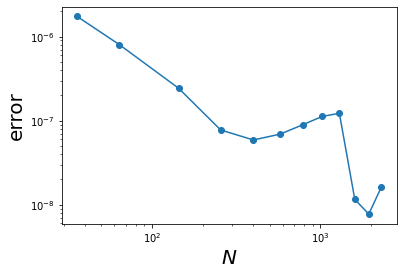

In [4]:
n_grids = np.array(n_grids)
#n_params = (4*n_grids-5)*n_grids
n_params = n_grids**2
#n_params = (n_grids-1)**2
plt.plot(n_params, errors, marker="o")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-8,10e-5)
plt.xlabel(r"$N$",fontsize=20)
plt.ylabel("error",fontsize=20)

In [231]:
start_id = -6
end_id = -1

(np.log(errors[start_id]) - np.log(errors[end_id]))/(np.log(n_params[start_id])-np.log(n_params[end_id]))

-1.9201069227039909

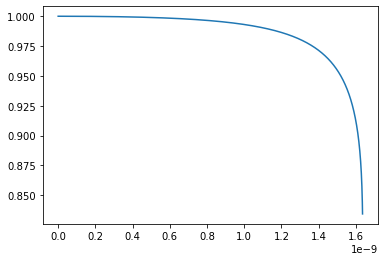

In [235]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

start_id = -6
end_id = -1
loss_w = errors[start_id:end_id]
log_ws = np.log(n_params[start_id:end_id])
log_loss = np.log(errors[start_id:end_id])

reg = LinearRegression().fit(log_ws[:,np.newaxis], log_loss)
eps_max = np.min(loss_w)*0.999

num_sweep = 10001
eps0_sweep = np.linspace(0, eps_max, num=num_sweep)
scores = []

for i in range(num_sweep):
    score = np.abs(scipy.stats.pearsonr(log_ws, np.log(loss_w-eps0_sweep[i]))[0])
    scores.append(score)
    
plt.plot(eps0_sweep, scores)

In [236]:
max_id = np.argmax(scores)
eps0 = eps0_sweep[max_id]
reg.fit(log_ws[:,np.newaxis], np.log(loss_w-eps0))
alpha = reg.coef_[0]
A = np.e**reg.intercept_
print(max_id)
print(eps0)
print(alpha)
print(A)
#[eps0, A, alpha]

0
0.0
-1.9184066707629372
0.0033148606783546743


In [237]:
from scipy.optimize import minimize

def f(x):
    eps0 = x[0]
    A = x[1]
    alpha = x[2]
    return np.mean((loss_w-(A*n_params[start_id:end_id]**alpha+eps0))**2)

x0 = np.array([eps0, A, alpha])
sol = minimize(f, x0, tol=1e-32, options={'gtol':1e-30})
sol

      fun: 5.549117469329293e-23
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([1.49027668e-08, 9.45245568e-18, 2.01377313e-19])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 236
      nit: 0
     njev: 56
   status: 2
  success: False
        x: array([ 0.        ,  0.00331486, -1.91840667])